Install packages

In [1]:
pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=f72b584b95607739b3194d85bfa299670fb9aec3b72f0a8e226204585b58f577
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [3]:
pip install fastcore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install fastdownload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [6]:
from fastcore.all import *

In [7]:
from fastdownload import download_url

In [8]:
from fastai.vision.all import *

In [9]:
from time import sleep

In [10]:
from fastai.metrics import error_rate

In [11]:
import requests

In [12]:
from bs4 import BeautifulSoup

In [13]:
import tempfile

In [14]:
import os

In [15]:
import random

In [27]:
from google.colab import drive

Functions

In [16]:
def search_images(word, max_images=20): #Limit 20 images, because Google API
    print(f'Start searching for {word}')
    
    url = f'https://www.google.com/search?q={word}&tbm=isch'
    content = requests.get(url).content
    soup = BeautifulSoup(content, 'html.parser')
    images = soup.findAll('img', class_='yWs4tf', limit=max_images)
    images = [url.get('src') for url in images if url is not None]
    print(f'Finish searching for {word}')
    
    return L(images)

In [17]:
def download_images_word(image_urls, word, path, image_effect):
    '''Downloads images of a given word and saves them to a given path.'''
    position = 0
    for url in image_urls:
        response = requests.get(url)
        with open(str(Path(path) / f'image_{word}_{image_effect}_{position}.jpg'), 'wb') as handler:
            handler.write(response.content)
        position += 1

Creating temp directory

In [18]:
with tempfile.TemporaryDirectory() as tmpdir:
    print('Created temporary directory:', tmpdir)

Created temporary directory: /tmp/tmp2ttvkjvs


Download url images from internet

In [19]:
searches = ['blueberry muffin food', 'chihuahua dog']
path = Path(tmpdir)
effect_list = ['normal', 'blur effect', 'shade effect']
for word in searches:
    destination = (path / word)
    destination.mkdir(exist_ok=True, parents=True)
    
    for effect in effect_list:
        download_images_word(search_images(f'{word} {effect} images'), word, destination, effect)
        sleep(10)

    resize_images(destination, max_size=400, destination=destination)

Start searching for blueberry muffin food normal images
Finish searching for blueberry muffin food normal images
Start searching for blueberry muffin food blur effect images
Finish searching for blueberry muffin food blur effect images
Start searching for blueberry muffin food shade effect images
Finish searching for blueberry muffin food shade effect images
Start searching for chihuahua dog normal images
Finish searching for chihuahua dog normal images
Start searching for chihuahua dog blur effect images
Finish searching for chihuahua dog blur effect images
Start searching for chihuahua dog shade effect images
Finish searching for chihuahua dog shade effect images


Confirm there are images in directory

In [20]:
image_extensions = ('.jpg', '.jpeg', '.png')
files = os.listdir(path)
has_images = any(file.endswith(image_extensions) for file in files)

if has_images:
    print('Directory contains image files')
else:
    print('Directory does not contain image files')

Directory does not contain image files


Removing not download correctly photos

In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Creating data loaders

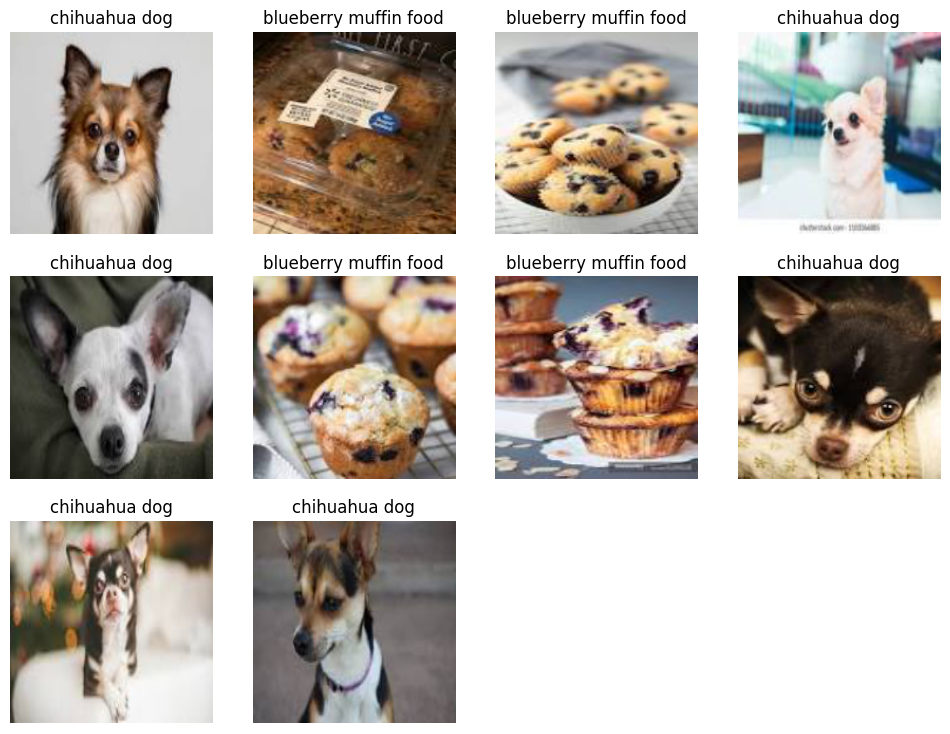

In [22]:
data_loader = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

data_loader.show_batch(max_n=10)

Training model

In [23]:
learner = vision_learner(data_loader, resnet18, metrics=error_rate)
learner.fine_tune(10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.784508,0.067628,0.041667,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.155036,0.038138,0.000000,00:01
1,0.101125,0.003948,0.000000,00:00
2,0.068992,0.001224,0.000000,00:00
3,0.050327,0.000608,0.000000,00:00
4,0.039714,0.000514,0.000000,00:00
5,0.032134,0.000491,0.000000,00:01
6,0.026913,0.000490,0.000000,00:01
7,0.022902,0.000555,0.000000,00:00
8,0.019735,0.000621,0.000000,00:00
9,0.017303,0.000650,0.000000,00:00


Testing

This is a: blueberry muffin food.
Probability it is a blueberry muffin: 1.0000
Probability it is a chihuahua: 0.0000


This is a: chihuahua dog.
Probability it is a blueberry muffin: 0.0000
Probability it is a chihuahua: 1.0000


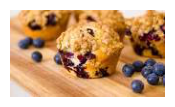

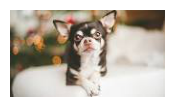

In [26]:
for word in searches:
  file_names = [file_image for file_image in os.listdir(path/word) if file_image.endswith('.jpg') or file_image.endswith('.png') or file_image.endswith('.jpeg')]
  random_file_name = random.choice(file_names)
  random_file_path = os.path.join(path/word, random_file_name)

  muffin_chihuahua,_,probs = learner.predict(PILImage.create(random_file_path))
  PILImage.create(random_file_path).show()
  
  print(f'This is a: {muffin_chihuahua}.')
  print(f'Probability it is a blueberry muffin: {probs[0]:.4f}')
  print(f'Probability it is a chihuahua: {1-probs[0]:.4f}')

Mount drive and export trained model

In [28]:
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
learner.export('trained_model_chihuahua_muffin.pkl')